In [2]:
import tensorflow as tf

# from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import geopandas as gpd
import datetime as dt
from datetime import datetime

from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import Image, ExifTags

# Import the function to investigate a table
from snowexsql.db import get_table_attributes

import snowexsql.db
from snowexsql.data import PointData, SiteData
from snowexsql.conversions import query_to_geopandas
# Import the function to get connect to the db
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

In [71]:
#!aws s3 sync --no-progress s3://snowex-data/tutorial-data/camera-trap/ /tmp/camera-trap

In [73]:

files = os.listdir('/tmp/camera-trap/W1A')
files =  ['/tmp/camera-trap/W1A/' + str(f) for f in files]

df = pd.DataFrame([],
                   columns=['date','photo_id','time','datetime','depth'])
for i in range(0,len(files)): 
    
    img = Image.open(files[i])
    exif = { ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS }
    exif['DateTime'] = datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
    df.loc[i]= [exif['DateTime'].date(),
                       files[i],
                       exif['DateTime'].time(),exif['DateTime'],np.nan]
for i in range(len(df)):
    pivot = df['datetime'][i]
    items = df_veg['datetime']
    tmp = np.where(items==pivot)[0]
    if len(np.where(items==pivot)[0])>0:
        idx = tmp[0]
        df['depth'][i] = df_veg['value'][idx]

pixels = []      
for i in range(0, len(df)):
    # img = cv2.imread(str(path)+"/"+str(img))
    # src = Image.open(str(path)+"/"+str(img))
    path = df['photo_id'][i]
    src = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    #calculate the 50 percent of original dimensions
    width =200 # int(src.shape[1] * scale_percent / 100)
    height = 200 # int(src.shape[0] * scale_percent / 100)
    # dsize
    dsize = (width, height)
    # resize image
    output = cv2.resize(src, dsize)
    cv2.imwrite('tmp.jpg',output) 
    # img1 = img.save('tmp', format='JPEG',dpi=(50,50))
    img2 = cv2.imread('tmp.jpg')
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
    pixels.append(np.array(img2))

pixels = np.array(pixels)



<ipython-input-73-e65b60701feb>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['depth'][i] = df_veg['value'][idx]


KeyboardInterrupt: 

In [3]:
#np.save('pixels_open.npy',pixels)
pixels=np.load('pixels_open.npy')

In [81]:
# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(PointData)

# Print out the results nicely
# print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))

# Grab the open site data from the db
open_site = 'W1A'
veg_site = 'W9A'
qry = session.query(PointData).filter(PointData.equipment.contains(open_site))
df_open = query_to_geopandas(qry,engine)

# Grab the vegetated site from the db
qry = session.query(PointData).filter(PointData.equipment.contains(veg_site))
df_veg = query_to_geopandas(qry,engine)

In [82]:
df = pd.DataFrame([],
                   columns=['date','photo_id','time','datetime','depth'])
for i in range(0,len(files)): 
    
    img = Image.open(files[i])
    exif = { ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS }
    exif['DateTime'] = datetime.strptime(exif['DateTime'],'%Y:%m:%d %H:%M:%S')
    df.loc[i]= [exif['DateTime'].date(),
                       files[i],
                       exif['DateTime'].time(),exif['DateTime'],np.nan]
    
df_open['datetime'] = [datetime.combine(df_open['date'][i],df_open['time'][i]).replace(tzinfo=None) for i in range(len(df_open))]


for i in range(len(df)):
    pivot = df['datetime'][i]
    items = df_open['datetime']
    tmp = np.where(items==pivot)[0]
    if len(np.where(items==pivot)[0])>0:
        idx = tmp[0]
        df['depth'][i] = df_open['value'][idx]

<ipython-input-82-39e47349d0a4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['depth'][i] = df_open['value'][idx]


In [83]:
len(df.loc[df['depth']>0])

319

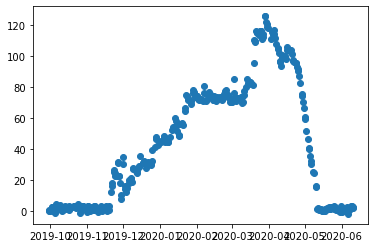

In [84]:
plt.plot(df['datetime'],df['depth'],'o')

In [ ]:
dataset = pixels.reshape((659,-1))
dataset = np.concatenate((dataset, np.array(df['depth']).reshape((659,1))),axis=1)
dataset=pd.DataFrame(dataset)


In [5]:
dataset=np.load('dataset_open.npy',allow_pickle=True)
dataset=dataset[dataset[:,-1]>0]

IndexError: index 120000 is out of bounds for axis 0 with size 659

In [14]:
dataset=pd.DataFrame(dataset)

In [15]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [16]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_dataset)
scaled_test = scaler.transform(test_dataset) ## fit_transform != transform. 
                                             ## transform uses the parameters of fit_transform

In [17]:
train_X, train_y = scaled_train[:, :-1], scaled_train[:, -1]
test_X, test_y = scaled_test[:, :-1], scaled_test[:, -1]

In [18]:
tf.random.set_seed(0) ## For reproducible results
linear_regression = tf.keras.models.Sequential() # Specify layers in their sequential order
# inputs are 4 dimensions (4 dimensions = 4 features)
# Dense = Fully Connected.  
linear_regression.add(tf.keras.layers.Dense(1, activation=None ,input_shape=(train_X.shape[1],)))
# Output layer has no activation with just 1 node

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
linear_regression.compile(optimizer = opt, loss='mean_squared_error')

In [20]:
print(linear_regression.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 120001    
Total params: 120,001
Trainable params: 120,001
Non-trainable params: 0
_________________________________________________________________
None


### should take about 1 minute

In [21]:
%%time
# NOTE: can changed from epochs=150 to run faster, change to verbose=1 for per-epoch output
history =linear_regression.fit(train_X, train_y, epochs=100, validation_split = 0.2, verbose=0)

CPU times: user 39.2 s, sys: 44.6 s, total: 1min 23s
Wall time: 42.4 s


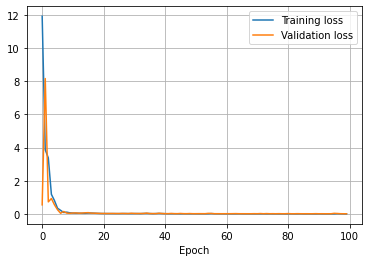

In [22]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

## now moving to neural net

In [23]:
tf.random.set_seed(1000)  ## For reproducible results
network = tf.keras.models.Sequential() # Specify layers in their sequential order
# inputs are 4 dimensions (4 dimensions = 4 features)
# Dense = Fully Connected.   
# First hidden layer has 1000 neurons with relu activations.
# Second hidden layer has 512 neurons with relu activations
# Third hidden layer has 256 neurons with Sigmoid activations
network.add(tf.keras.layers.Dense(1000, activation='relu' ,input_shape=(train_X.shape[1],)))
network.add(tf.keras.layers.Dense(512, activation='relu')) # sigmoid, tanh
network.add(tf.keras.layers.Dense(256, activation='sigmoid'))
# Output layer uses no activation with 1 output neurons
network.add(tf.keras.layers.Dense(1)) # Output layer

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
network.compile(optimizer = opt, loss='mean_squared_error')

## run neural net
can take several minutes! use fewer epochs to decrease time

In [25]:
%%time

# NOTE: if you have time, consider upping epochs -> 150
history =network.fit(train_X, train_y, epochs=20, validation_split = 0.2, verbose=0)

CPU times: user 3min 2s, sys: 51.2 s, total: 3min 53s
Wall time: 1min 57s


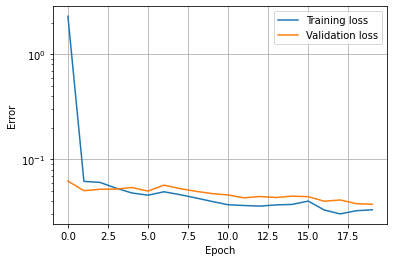

In [27]:
plt.semilogy(history.history['loss'], label='Training loss')
plt.semilogy(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

In [28]:
## Linear Regression

yhat_linReg = linear_regression.predict(test_X)
inv_yhat_linReg = np.concatenate((test_X, yhat_linReg), axis=1)
inv_yhat_linReg = scaler.inverse_transform(inv_yhat_linReg)
inv_yhat_linReg = inv_yhat_linReg[:,-1]

## DNN
yhat_dnn = network.predict(test_X) 
inv_yhat_dnn = np.concatenate((test_X, yhat_dnn), axis=1)
inv_yhat_dnn = scaler.inverse_transform(inv_yhat_dnn)
inv_yhat_dnn = inv_yhat_dnn[:,-1]

## True Snow Depth (Test Set)
inv_y = test_y


## Put Observed and Predicted (Linear Regression and DNN) in a Dataframe
prediction_df = pd.DataFrame({"Observed": inv_y,
                    "LR":inv_yhat_linReg, "DNN":inv_yhat_dnn})

In [29]:
def metrics_print(test_data,test_predict):
    print('Test RMSE: ', round(np.sqrt(mean_squared_error(test_data, test_predict)), 2))
    print('Test R^2 : ', round((r2_score(test_data, test_predict)*100), 2) ,"%")
    print('Test MAPE: ', round(mean_absolute_percentage_error(test_data, test_predict)*100,2), '%')

In [30]:
print("##************** Linear Regression Results **************##")
metrics_print(prediction_df['Observed'], prediction_df['LR'])
print(" ")
print(" ")

print("##************** Deep Learning Results **************##")
metrics_print(prediction_df['Observed'], prediction_df['DNN'])
print(" ")
print(" ")

##************** Linear Regression Results **************##
Test RMSE:  60.61
Test R^2 :  -3760223.81 %
Test MAPE:  2.869803970975345e+17 %
 
 
##************** Deep Learning Results **************##
Test RMSE:  55.14
Test R^2 :  -3112158.39 %
Test MAPE:  9.216806130225435e+16 %
 
 


Text(0.5, 1.0, 'Deep Neural Network')

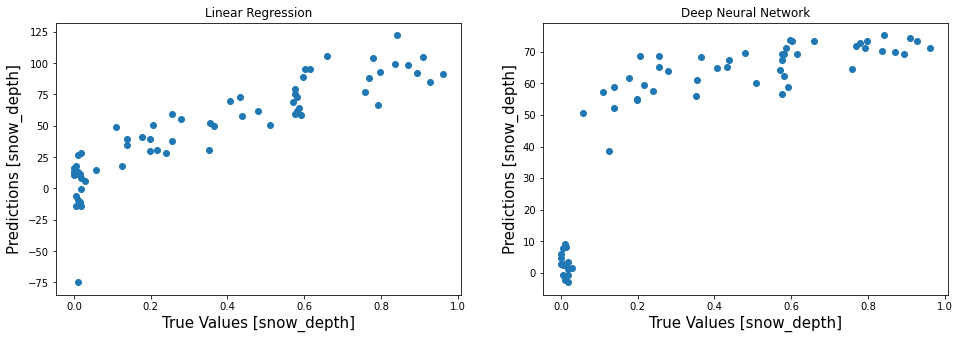

In [31]:
fa = plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.scatter(prediction_df['Observed'],prediction_df['LR'])
plt.xlabel('True Values [snow_depth]', fontsize=15)
plt.ylabel('Predictions [snow_depth]', fontsize=15)
plt.title("Linear Regression")


plt.subplot(1,2,2)
plt.scatter(prediction_df['Observed'],prediction_df['DNN'])
plt.xlabel('True Values [snow_depth]', fontsize=15)
plt.ylabel('Predictions [snow_depth]', fontsize=15)
plt.title("Deep Neural Network")


Text(0.5, 1.0, 'Deep Neural Network')

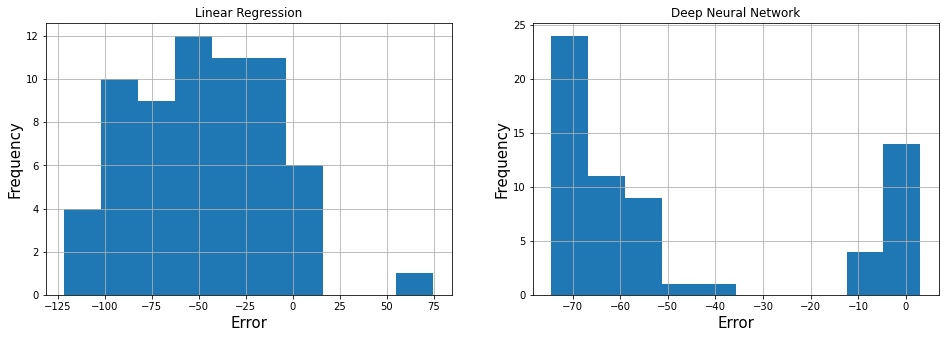

In [32]:
LR_error = prediction_df['Observed'] - prediction_df['LR']
DNN_error = prediction_df['Observed'] - prediction_df['DNN']

fa = plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
LR_error.hist()
plt.xlabel('Error', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Linear Regression")

plt.subplot(1,2,2)
DNN_error.hist()
plt.xlabel('Error', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Deep Neural Network")